In [119]:
# please put all the package used here
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
import requests
import json
warnings.filterwarnings('ignore')
import psycopg2
import psycopg2.extras
import time
import ast # convert string to dictionary
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns  
sns.set_context('notebook')    
import statsmodels.formula.api as smf
import math as ma
from scipy import stats
import statsmodels.api as sm
import shapefile as shp
import shapefile
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon




In [120]:
real_walkable ={   # Sydney's most walkable suburbs
    'Sydney - Haymarket - The Rocks': 99,
    'Pyrmont - Ultimo': 98,
    'Surry Hills': 97,
    'Redfern - Chippendale':97,
    'Darlinghurst': 96,
    'Newtown - Camperdown - Darlington': 95,          
    'Holsworthy Military Area':0
}



large_area_walk_score = {
    'Blue Mountains - South':0,
    'Bilpin - Colo - St Albans':0,
    'Calga - Kulnura':0,
    'Blue Mountains - North':0,
    'Dural - Kenthurst - Wisemans Ferry':0,
    'Jilliby - Yarramalong':3,
    'Kurrajong Heights - Ebenezer':0,
    'The Oaks - Oakdale':34,
    'Douglas Park - Appin':12,
    'Galston - Laughtondale':54,
    'Picton - Tahmoor - Buxton':20,
    'Mulgoa - Luddenham - Orchard Hills':1,
    'Royal National Park':2,
    'Blackheath - Megalong Valley':63,
    'Cobbitty - Leppington':4,
    'Holsworthy Military Area':0,
    'Ourimbah - Fountaindale':3,
    'Austral - Greendale':0,
    'Berowra - Brooklyn - Cowan':56,
    'Pitt Town - McGraths Hill':7,
    'Yarramundi - Londonderry':18,
    'Riverstone - Marsden Park':0,
    'Richmond - Clarendon':17,
}

In [121]:
def z_score(df):
    df.columns = [x + "_zscore" for x in df.columns.tolist()]
    return ((df - df.mean())/df.std(ddof=0))


In [122]:
def min_max_norm(dataset):
    
    if isinstance(dataset,list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value)*100 / (max_value - min_value)
            norm_list.append(tmp)

    return norm_list

In [123]:
data_BusinessStats = pd.read_csv('new_BusinessStats.csv')
data_CensusStats = pd.read_csv('new_CensusStats.csv')
data = pd.read_csv('exact_matching.csv')

In [124]:
data["median_annual_household_income"] = data_CensusStats["median_annual_household_income"]
data["avg_monthly_rent"] = data_CensusStats["avg_monthly_rent"]

# Generate balance by add sum z score with weight

In [125]:
def calculate_balance():
    w1 = float(input("Please input weight for retail trade: "))
    w2 = float(input("Please input weight for accommodation_and_food_services: "))
    w3 = float(input("Please input weight for health_care_and_social_assistance: "))
    w4 = float(input("Please input weight for education_and_training: "))
    w5 = float(input("Please input weight for arts_and_recreation_services: "))
    data["buss_type_banace"]=np.nan
    count = 0
    for j in data_BusinessStats['area_id']:
        for i in data["area_id"]:
            if i == j:
                sum_balance = (w1*data_BusinessStats['retail_trade_z'][count] + w2*data_BusinessStats['accommodation_and_food_services_z'][count] + w3*data_BusinessStats['health_care_and_social_assistance_z'][count] + w4*data_BusinessStats['education_and_training_z'][count] + w5*data_BusinessStats['arts_and_recreation_services_z'][count])
                data["buss_type_banace"][count] = sum_balance       
        count += 1
    #return data["buss_type_banace"].head()

In [126]:
def Check_reasonable(dic):
    for k1,v1 in dic.items():
        count = 0
        for i in data["area_name"]:
            if i == k1:
                score = int(data["walkability"][count])
                if abs(float(v1) - float(score)) <5:
                    print("👍🏻 Good Estimation for {}!".format(i))
                    print(" {} has real score {}, but our calculation is {}".format(i,v1,score))
                    break;
                elif abs(float(v1) - float(score))>20:
                    print("😞 Shit! Poor estimation for {}".format(i))
                print(" {} has real score {}, but our calculation is {}".format(i,v1,score))
                break;
            count += 1
              

# Equal weight
BaseLines, just add four column up to genetrate z score

## Z score of carPods

In [127]:
data[['librarybookstore_z']]=z_score(data[['librarybookstore_num']])
data[['parksplaygrounds_z']]=z_score(data[['parksplaygrounds_num']])
data[['trainstation_z']]=z_score(data[['trainstation_num']])
data[['area_z_score']]=z_score(data[['land_area']]) # ⚙️⚙️⚙️ new variable
#data['busstops_num1'] = data['busstops_num']/data['land_area']
#data[['busstops_z']]=z_score(data[['busstops_num1']])

In [128]:
np.log(data['busstops_num']+1).head()

0    4.110874
1    4.718499
2    4.488636
3    4.983607
4    5.198497
Name: busstops_num, dtype: float64

In [129]:
np.log(data['busstops_num']+1).head()

0    4.110874
1    4.718499
2    4.488636
3    4.983607
4    5.198497
Name: busstops_num, dtype: float64

In [130]:
data["population_density_z"] = data["ZP"]
data['dwelling_density_z'] = data['ZD']
data['transport_density_z'] = data['ZT']
del data["ZP"]
del data['ZD']
del data['ZT']

In [131]:

calculate_balance()

# new column
data["walkability"] = 2*data["population_density_z"] + 3*data['dwelling_density_z'] + 3*data['transport_density_z'] 
data["walkability"] = data["walkability"] + 2*data["buss_type_banace"] - 2*data['area_z_score']
data["walkability"] = data["walkability"] + 2*np.log(data['busstops_num']+1)
data["walkability"] = data["walkability"] + (data['librarybookstore_num']+data['parksplaygrounds_num'])/100 
data["walkability"] = data["walkability"] + data['trainstation_num']/100

scaled_walkability = min_max_norm(list(data["walkability"])) # walkabilility should be integer

# round to Integer
for i in range(len(scaled_walkability)):
    scaled_walkability[i] = round(scaled_walkability[i])

data["walkability"]=scaled_walkability   

corr_median_income = data_CensusStats["median_annual_household_income"].corr(data["walkability"])
corr_monthly_rent = data_CensusStats["avg_monthly_rent"].corr(data["walkability"])
print(corr_median_income)
print(corr_monthly_rent)

Please input weight for retail trade: 1
Please input weight for accommodation_and_food_services: 1
Please input weight for health_care_and_social_assistance: 1
Please input weight for education_and_training: 1
Please input weight for arts_and_recreation_services: 1
0.46386610469734363
0.5430275438601629


In [133]:
Check_reasonable(real_walkable)
Check_reasonable(large_area_walk_score)

😞 Shit! Poor estimation for Sydney - Haymarket - The Rocks
 Sydney - Haymarket - The Rocks has real score 99, but our calculation is 74
😞 Shit! Poor estimation for Pyrmont - Ultimo
 Pyrmont - Ultimo has real score 98, but our calculation is 72
 Surry Hills has real score 97, but our calculation is 90
 Redfern - Chippendale has real score 97, but our calculation is 88
 Darlinghurst has real score 96, but our calculation is 89
 Newtown - Camperdown - Darlington has real score 95, but our calculation is 100
😞 Shit! Poor estimation for Holsworthy Military Area
 Holsworthy Military Area has real score 0, but our calculation is 35
👍🏻 Good Estimation for Blue Mountains - South!
 Blue Mountains - South has real score 0, but our calculation is 0
 Bilpin - Colo - St Albans has real score 0, but our calculation is 9
😞 Shit! Poor estimation for Calga - Kulnura
 Calga - Kulnura has real score 0, but our calculation is 37
 Blue Mountains - North has real score 0, but our calculation is 9
😞 Shit! Poo

## Sydney's most walkable suburbs

# Walkability visulization

## Corr : linear relationship !

(0, 3000)

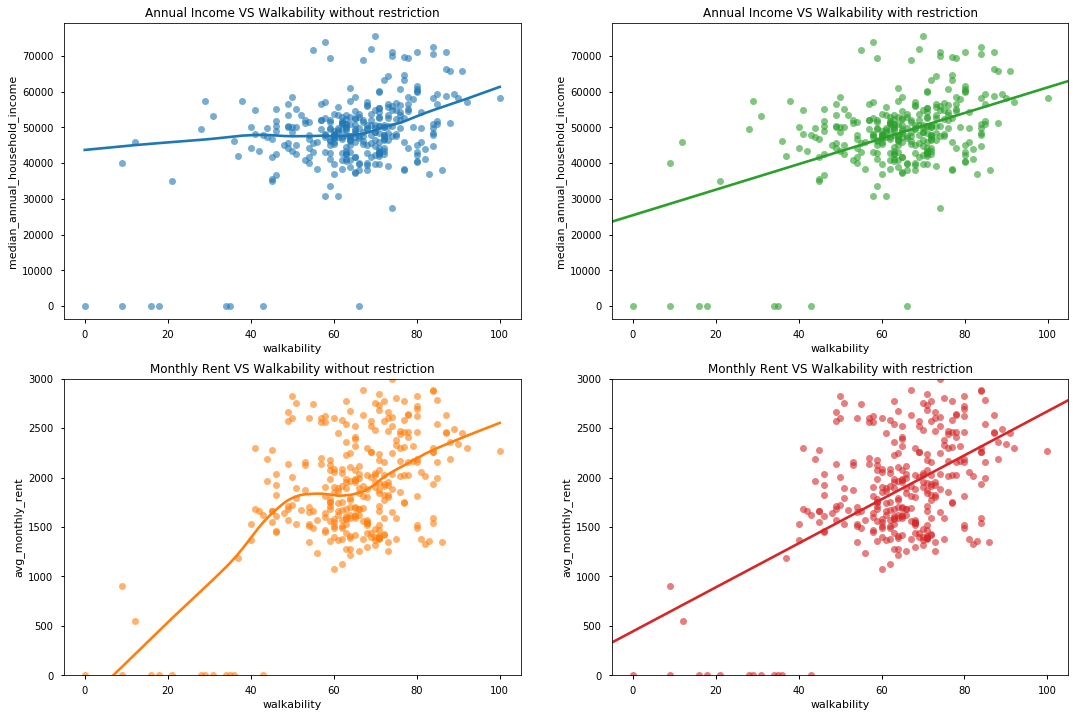

In [134]:
fig, ax= plt.subplots(2,2, figsize=(18,12))
sns.regplot(data["walkability"], data_CensusStats["median_annual_household_income"], ax=ax[0,0],ci=True, lowess=True, scatter_kws={'alpha':0.6})
ax[0,0].set(title='Annual Income VS Walkability without restriction',xlabel='walkability')
#ax[0,0].set_ylim(0,7500)

sns.regplot(data["walkability"], data_CensusStats["avg_monthly_rent"], ax=ax[1,0],ci=True, lowess=True,scatter_kws={'alpha':0.6})
ax[1,0].set(title='Monthly Rent VS Walkability without restriction',xlabel='walkability')
#ax[0,1].set_ylim(0,7500)

sns.regplot(data["walkability"], data_CensusStats["median_annual_household_income"], ax=ax[0,1],ci=True, scatter_kws={'alpha':0.6})
ax[0,1].set(title='Annual Income VS Walkability with restriction',xlabel='walkability')
ax[1,0].set_ylim(0,3000)

sns.regplot(data["walkability"], data_CensusStats["avg_monthly_rent"], ax=ax[1,1],ci=True, scatter_kws={'alpha':0.6})
ax[1,1].set(title='Monthly Rent VS Walkability with restriction',xlabel='walkability')
ax[1,1].set_ylim(0,3000)




### Intuitively，strong linear relationship bet them！ then， calculate corr

## Map Visulization

In [135]:
def read_shapefile_sydney_only(shp_path, sydney_list, sydney_path1):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """
    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    sf1 = shapefile.Reader(sydney_path1)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    records_sydney = []
    for i in records:
        for k in sydney_list:
            if str(i[0]) == str(k):
                records_sydney.append(i)
           
    shps = [s.points for s in sf1.shapes()]
    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records_sydney)
    df = df.assign(coords=shps)
    
    # check output file
    count = 0
    for i in df["SA2_MAIN16"]:
        for j in sydney_list:
            if int(j) == int(i):
                count += 1
    if count == 312:
        print("👍🏻 Finish checking, and our output file includes {} Sydney area".format(count))
   
    return df

In [136]:
data_Neighbourhoods = pd.read_csv('Neighbourhoods.csv')
data_abs_Sydney = read_shapefile_sydney_only('SA2_2016_AUST.shp', data_Neighbourhoods["area_id"], 'Sydney2_2016_AUST.shp')

👍🏻 Finish checking, and our output file includes 312 Sydney area


In [137]:
data_abs_Sydney.head()

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,coords
0,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,"[(151.4137275700001, -33.46559324899994), (151..."
1,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,"[(151.3539836770001, -33.49854010299998), (151..."
2,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,"[(151.20459505400004, -33.53298299599993), (15..."
3,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,"[(151.36794832200007, -33.43822416399996), (15..."
4,102011032,11032,Gosford - Springfield,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,16.9124,"[(151.310060818, -33.42698909599994), (151.310..."


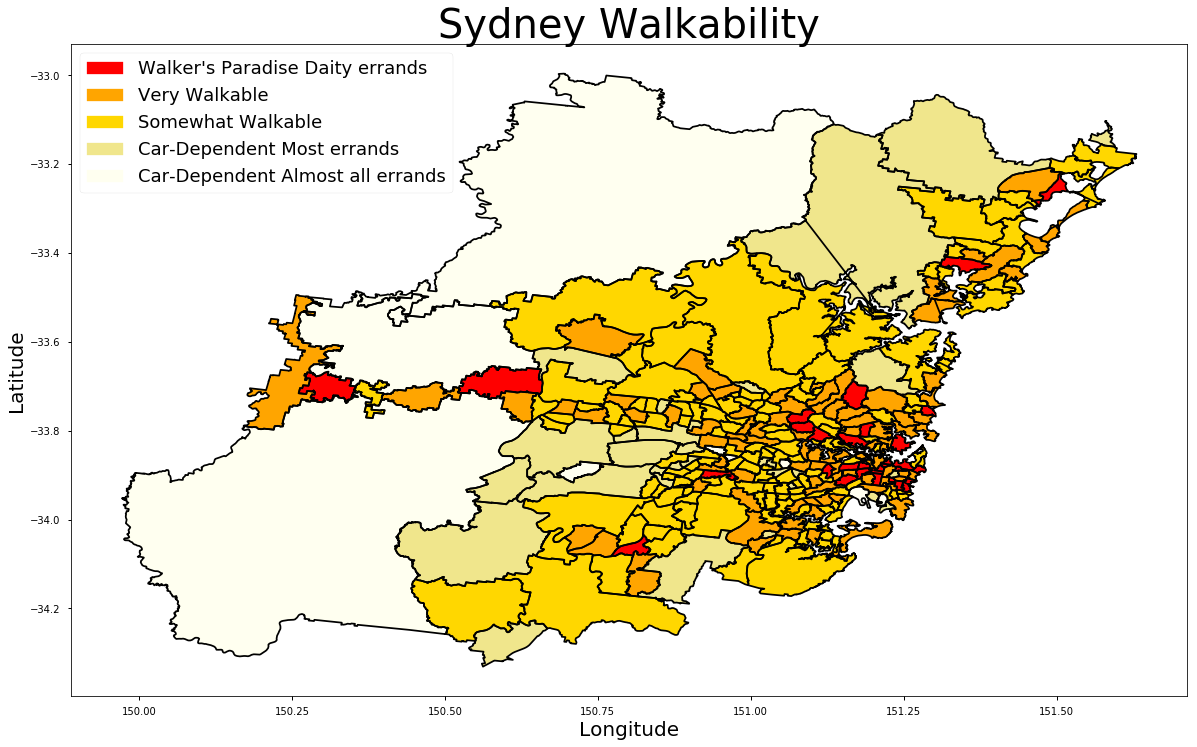

In [138]:
import shapefile as shp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sf = shp.Reader("Sydney2_2016_AUST.shp")

plt.figure(figsize=(20,12))
walk_score = data["walkability"]
count =0
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color = 'k')
    # fill color by walk score
    if data["walkability"][count] <= 30:
        plt.fill(x,y,"ivory")
    # fill color by walk score
    elif data["walkability"][count] <= 49:
        plt.fill(x,y,"khaki")
    # fill color by walk score
    elif data["walkability"][count] <= 69:
        plt.fill(x,y,"gold")
    # fill color by walk score
    elif data["walkability"][count] <= 80:
        plt.fill(x,y,"orange")
    # fill color by walk score
    else:                     # 90-100
        plt.fill(x,y,"red") 
    count += 1
# display
red_patch = mpatches.Patch(color='red', label="Walker's Paradise Daity errands")
origen_patch = mpatches.Patch(color='orange', label="Very Walkable")
gold_patch = mpatches.Patch(color='gold', label="Somewhat Walkable")
khaki_patch = mpatches.Patch(color='khaki', label="Car-Dependent Most errands")
ivory_patch = mpatches.Patch(color='ivory', label="Car-Dependent Almost all errands")
plt.legend(handles=[red_patch,origen_patch,gold_patch,khaki_patch,ivory_patch],fontsize=18)

plt.title("Sydney Walkability", fontsize=40)
plt.ylabel('Latitude', fontsize=20)
plt.xlabel('Longitude', fontsize=20)

plt.show()

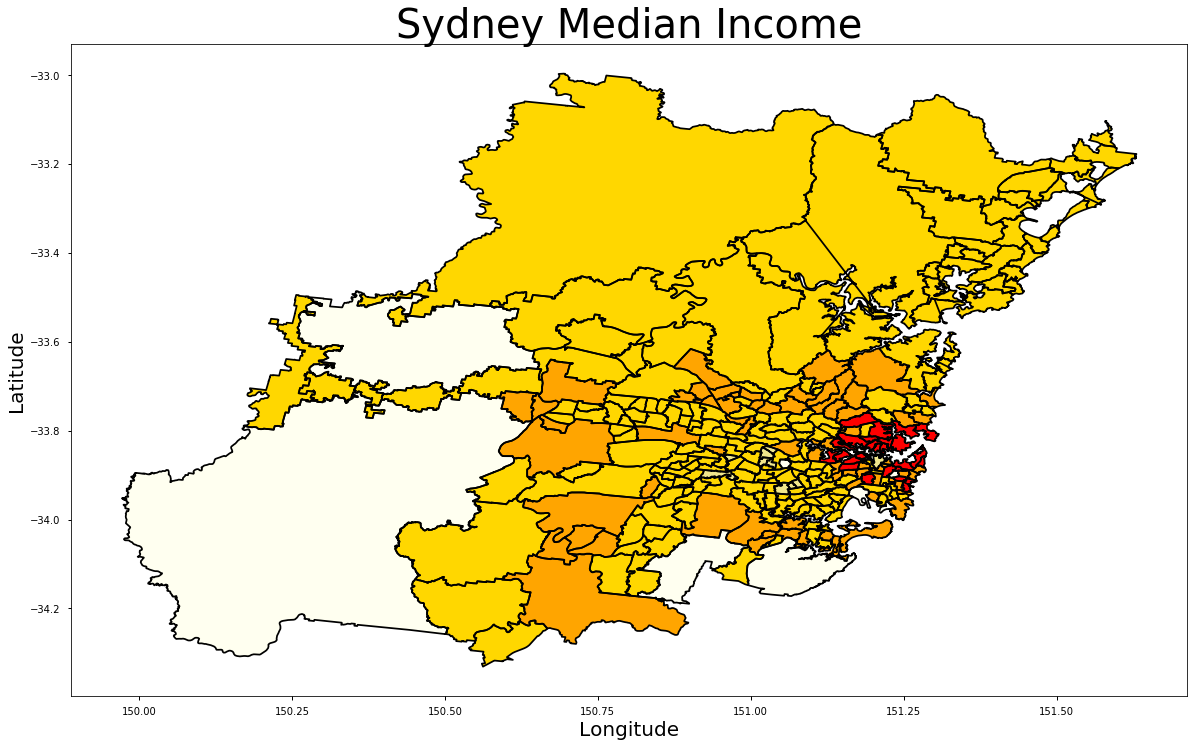

In [139]:
sf = shp.Reader("Sydney2_2016_AUST.shp")

plt.figure(figsize=(20,12))
scaled_walkability = min_max_norm(list(data_CensusStats["median_annual_household_income"])) # walkabilility should be integer
data_CensusStats["median_annual_household_income"]=scaled_walkability   

count =0
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color = 'k')
    # fill color by walk score
    if data_CensusStats["median_annual_household_income"][count] <= 30:
        plt.fill(x,y,"ivory")
    # fill color by walk score
    elif data_CensusStats["median_annual_household_income"][count] <= 49:
        plt.fill(x,y,"khaki")
    # fill color by walk score
    elif data_CensusStats["median_annual_household_income"][count] <= 69:
        plt.fill(x,y,"gold")
    # fill color by walk score
    elif data_CensusStats["median_annual_household_income"][count] <= 80:
        plt.fill(x,y,"orange")
    # fill color by walk score
    else:                     # 90-100
        plt.fill(x,y,"red") 
    count += 1
'''
# display
red_patch = mpatches.Patch(color='red', label="Walker's Paradise Daily errands")
origen_patch = mpatches.Patch(color='orange', label="Very Walkable")
gold_patch = mpatches.Patch(color='gold', label="Somewhat Walkable")
khaki_patch = mpatches.Patch(color='khaki', label="Car-Dependent Most errands")
ivory_patch = mpatches.Patch(color='ivory', label="Car-Dependent Almost all errands")
plt.legend(handles=[red_patch,origen_patch,gold_patch,khaki_patch,ivory_patch],fontsize=18)
'''
plt.title("Sydney Median Income", fontsize=40)
plt.ylabel('Latitude', fontsize=20)
plt.xlabel('Longitude', fontsize=20)

plt.show()

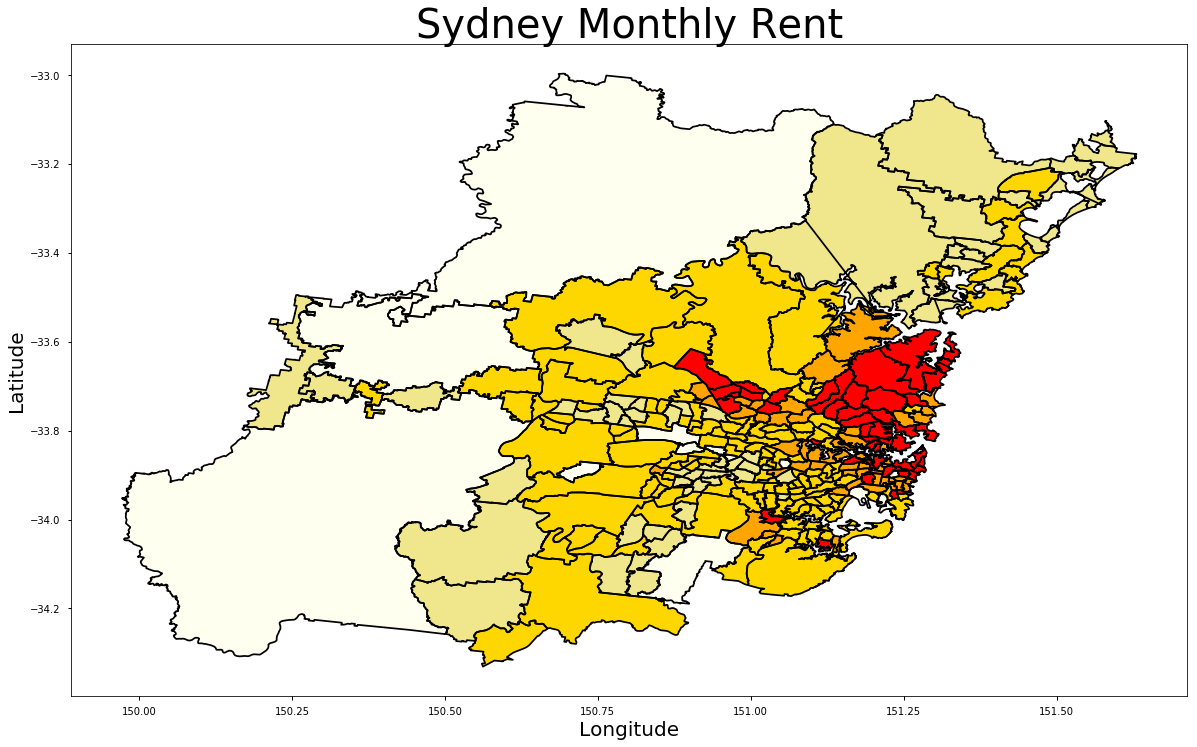

In [140]:
sf = shp.Reader("Sydney2_2016_AUST.shp")

plt.figure(figsize=(20,12))
scaled_walkability = min_max_norm(list(data_CensusStats["avg_monthly_rent"])) # walkabilility should be integer
data_CensusStats["avg_monthly_rent"]=scaled_walkability   
count =0
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, color = 'k')
    # fill color by walk score
    if data_CensusStats["avg_monthly_rent"][count] <= 30:
        plt.fill(x,y,"ivory")
    # fill color by walk score
    elif data_CensusStats["avg_monthly_rent"][count] <= 49:
        plt.fill(x,y,"khaki")
    # fill color by walk score
    elif data_CensusStats["avg_monthly_rent"][count] <= 69:
        plt.fill(x,y,"gold")
    # fill color by walk score
    elif data_CensusStats["avg_monthly_rent"][count] <= 80:
        plt.fill(x,y,"orange")
    # fill color by walk score
    else:                     # 90-100
        plt.fill(x,y,"red") 
    count += 1
'''
# display
red_patch = mpatches.Patch(color='red', label="Walker's Paradise Daily errands")
origen_patch = mpatches.Patch(color='orange', label="Very Walkable")
gold_patch = mpatches.Patch(color='gold', label="Somewhat Walkable")
khaki_patch = mpatches.Patch(color='khaki', label="Car-Dependent Most errands")
ivory_patch = mpatches.Patch(color='ivory', label="Car-Dependent Almost all errands")
plt.legend(handles=[red_patch,origen_patch,gold_patch,khaki_patch,ivory_patch],fontsize=18)
'''
plt.title("Sydney Monthly Rent", fontsize=40)
plt.ylabel('Latitude', fontsize=20)
plt.xlabel('Longitude', fontsize=20)

plt.show()

In [141]:
del data['land_area']
del data['population']
del data['number_of_dwellings']
del data['median_annual_household_income']
del data['avg_monthly_rent']
del data['librarybookstore_z']
del data['parksplaygrounds_z']
del data['trainstation_z']

In [142]:
data['service_balance'] = data['buss_type_banace']
del data['buss_type_banace']


In [143]:
data.to_csv("result.csv",index=False)